## Predict sentiment score of cryptocurrencies c with Fedot.Industrial

By combining historical sentiment data for 4 cryptocurrencies, extracted from EODHistoricalData31 and made available, with historical price data for the same cryptocurrencies, extracted from CryptoDataDownload32, was created the **BitcoinSentiment, EthereumSentiment, CardanoSentiment, and BinanceCoinSentiment** datasets, with 332, 356, 107, and 263 total instances, respectively. In all four datasets, the **predictors** are hourly **close price (in USD)** and **traded volume** for each respective cryptocurrency during a day, resulting in 2-dimensional time series of length 24. The **target variable** is the **normalized sentiment score** on the day spanned by the timepoints. The datasets were split
into train and test sets by randomly selecting 30% of each set as test data.
Link to the dataset - https://www.kaggle.com/datasets/gautamchettiar/historical-sentiment-data-btc-eth-bnb-ada

In [1]:
import pandas as pd
from fedot_ind.tools.loader import DataLoader
from examples.example_utils import init_input_data

D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


The list of basic fedot industrial models for experiment are shown below. We are using simple linear machine learning pipelines with 3 different feature generators: Statistical, Recurrence, Topological. And for each of them we add PCA transformation with 90 % of explained dispersion.

In [2]:
from cases.utils import ts_regression_setup
dataset_name = 'BitcoinSentiment'
OperationTypesRepository, tuning_params, data_path, experiment_setup, model_dict = ts_regression_setup()
experiment_setup['output_folder'] = f'./{dataset_name}/results_of_experiment'

Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [3]:
_, train_data, test_data = DataLoader(dataset_name=dataset_name).read_train_test_files(
            dataset_name=dataset_name,
            data_path=data_path)

2024-01-18 12:35:12,535 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS/examples/data/BitcoinSentiment


In [4]:
input_data = init_input_data(train_data[0], train_data[1], task=tuning_params['task'])
val_data = init_input_data(test_data[0], test_data[1], task=tuning_params['task'])

Lets check our data.

In [5]:
input_data.features.shape

(232, 2, 24)

Lets visualise our predictors.

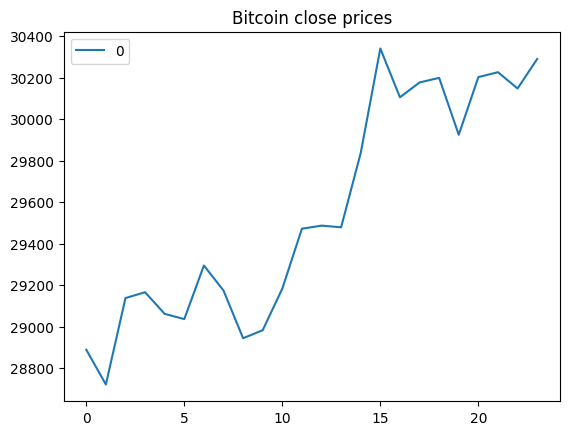

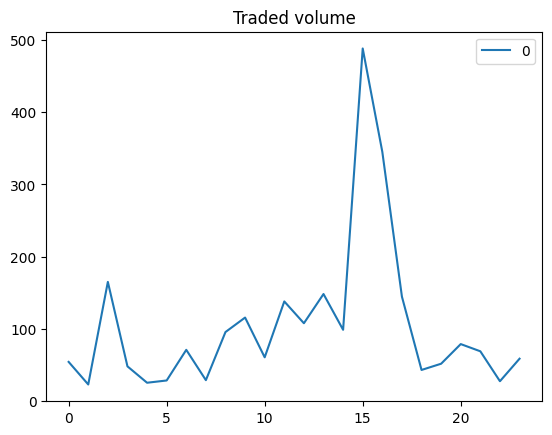

In [6]:
from matplotlib import pyplot as plt
pd.DataFrame(input_data.features[1, 0, :]).plot(title='Bitcoin close prices')
pd.DataFrame(input_data.features[1, 1, :]).plot(title='Traded volume')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [13]:
from cases.utils import evaluate_industrial_model
metric_dict = evaluate_industrial_model(input_data=input_data,
                                        val_data=val_data,
                                        model_dict=model_dict)

Current_model - regression_with_statistical_features


100%|██████████| 100/100 [00:00<00:00, 887.31it/s]


At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [14]:
df_baseline = pd.concat([x for x in metric_dict.values()],axis=1)
df_baseline.columns = list(metric_dict.keys())
df_baseline = df_baseline.T
df_baseline.sort_values(by='root_mean_squared_error:')

,r2_score:,mean_squared_error:,root_mean_squared_error:,mean_absolute_error,median_absolute_error,explained_variance_score,max_error,d2_absolute_error_score
regression_with_statistical_features,0.251186,0.055532,0.235652,0.15993,0.116833,0.297452,0.996398,0.24421


In [15]:
best_baseline = df_baseline.sort_values('root_mean_squared_error:')['root_mean_squared_error:'].iloc[0]

## Could it be done better? Tuning approach

In [8]:
from cases.utils import finetune
metric_dict = finetune(tuning_params, model_dict, train_data, test_data, val_data, input_data)

Current_model - regression_with_statistical_features


100%|██████████| 47/47 [00:00<00:00, 581.80it/s]

2024-01-18 13:30:55,157 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [ridge, quantile_extractor]}
ridge - {}
quantile_extractor - {'window_size': 0} 
Initial metric: [0.212]
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]


  0%|          | 0/185 [00:00<?, ?it/s]

 71%|#######1  | 132/185 [00:00<00:00, 1025.99it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 1122.04it/s]


 33%|███▎      | 1/3 [00:00<00:00,  2.23trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 71%|#######1  | 132/185 [00:00<00:00, 1010.33it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 1122.02it/s]


 67%|██████▋   | 2/3 [00:00<00:00,  2.32trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 45%|####5     | 84/185 [00:00<00:00, 779.86it/s]

 97%|#########7| 180/185 [00:00<00:00, 818.64it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 942.52it/s]


 10%|█         | 3/30 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/185 [00:00<?, ?it/s]

 45%|####5     | 84/185 [00:00<00:00, 576.88it/s]

 97%|#########7| 180/185 [00:00<00:00, 574.44it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 673.22it/s]


 13%|█▎        | 4/30 [00:00<00:19,  1.37trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 32%|###2      | 60/185 [00:00<00:00, 589.81it/s]

 71%|#######1  | 132/185 [00:00<00:00, 564.75it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 654.52it/s]


 17%|█▋        | 5/30 [00:01<00:17,  1.42trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 32%|###2      | 60/185 [00:00<00:00, 595.65it/s]

 71%|#######1  | 132/185 [00:00<00:00, 566.71it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 693.02it/s]


 20%|██        | 6/30 [00:02<00:16,  1.43trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 45%|####5     | 84/185 [00:00<00:00, 809.85it/s]

 97%|#########7| 180/185 [00:00<00:00, 868.09it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 1122.05it/s]


 23%|██▎       | 7/30 [00:02<00:13,  1.68trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 45%|####5     | 84/185 [00:00<00:00, 597.33it/s]

 97%|#########7| 180/185 [00:00<00:00, 586.38it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 772.54it/s]


 27%|██▋       | 8/30 [00:03<00:13,  1.67trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 45%|####5     | 84/185 [00:00<00:00, 526.40it/s]

 97%|#########7| 180/185 [00:00<00:00, 470.34it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 703.36it/s]


 30%|███       | 9/30 [00:03<00:13,  1.56trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 45%|####5     | 84/185 [00:00<00:00, 554.11it/s]

 97%|#########7| 180/185 [00:00<00:00, 545.76it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 736.33it/s]


 33%|███▎      | 10/30 [00:04<00:12,  1.55trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 32%|###2      | 60/185 [00:00<00:00, 567.54it/s]

 71%|#######1  | 132/185 [00:00<00:00, 568.11it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 693.02it/s]


 37%|███▋      | 11/30 [00:05<00:12,  1.52trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 45%|####5     | 84/185 [00:00<00:00, 546.91it/s]

 97%|#########7| 180/185 [00:00<00:00, 560.74it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 725.01it/s]


 40%|████      | 12/30 [00:05<00:11,  1.53trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 45%|####5     | 84/185 [00:00<00:00, 498.37it/s]

 97%|#########7| 180/185 [00:00<00:00, 477.14it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 673.22it/s]


 43%|████▎     | 13/30 [00:06<00:11,  1.47trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 32%|###2      | 60/185 [00:00<00:00, 595.64it/s]

 71%|#######1  | 132/185 [00:00<00:00, 566.71it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 574.71it/s]


 47%|████▋     | 14/30 [00:07<00:11,  1.42trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 32%|###2      | 60/185 [00:00<00:00, 541.99it/s]

 71%|#######1  | 132/185 [00:00<00:00, 495.47it/s]

 99%|#########8| 183/185 [00:00<00:00, 433.57it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 663.74it/s]


 50%|█████     | 15/30 [00:08<00:11,  1.33trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 45%|####5     | 84/185 [00:00<00:00, 554.11it/s]

 97%|#########7| 180/185 [00:00<00:00, 555.53it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 748.02it/s]


 53%|█████▎    | 16/30 [00:08<00:10,  1.39trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 45%|####5     | 84/185 [00:00<00:00, 546.91it/s]

 97%|#########7| 180/185 [00:00<00:00, 544.99it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 760.09it/s]


 57%|█████▋    | 17/30 [00:09<00:08,  1.45trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 45%|####5     | 84/185 [00:00<00:00, 536.46it/s]

 97%|#########7| 180/185 [00:00<00:00, 522.78it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 673.23it/s]


 60%|██████    | 18/30 [00:10<00:08,  1.45trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 45%|####5     | 84/185 [00:00<00:00, 593.12it/s]

 97%|#########7| 180/185 [00:00<00:00, 565.65it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 725.01it/s]


 63%|██████▎   | 19/30 [00:10<00:07,  1.48trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 32%|###2      | 60/185 [00:00<00:00, 589.80it/s]

 71%|#######1  | 132/185 [00:00<00:00, 573.24it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 748.03it/s]


 67%|██████▋   | 20/30 [00:11<00:06,  1.50trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 32%|###2      | 60/185 [00:00<00:00, 595.65it/s]

 71%|#######1  | 132/185 [00:00<00:00, 596.27it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 636.83it/s]


 70%|███████   | 21/30 [00:12<00:06,  1.43trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 32%|###2      | 60/185 [00:00<00:00, 562.24it/s]

 71%|#######1  | 132/185 [00:00<00:00, 568.96it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 612.02it/s]


 73%|███████▎  | 22/30 [00:12<00:05,  1.43trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 32%|###2      | 60/185 [00:00<00:00, 578.46it/s]

 71%|#######1  | 132/185 [00:00<00:00, 552.73it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 673.22it/s]


 77%|███████▋  | 23/30 [00:13<00:04,  1.41trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 45%|####5     | 84/185 [00:00<00:00, 550.48it/s]

 97%|#########7| 180/185 [00:00<00:00, 556.12it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 725.01it/s]


 80%|████████  | 24/30 [00:14<00:04,  1.44trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 45%|####5     | 84/185 [00:00<00:00, 526.40it/s]

 97%|#########7| 180/185 [00:00<00:00, 503.94it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 682.98it/s]


 83%|████████▎ | 25/30 [00:15<00:03,  1.43trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 45%|####5     | 84/185 [00:00<00:00, 519.90it/s]

 97%|#########7| 180/185 [00:00<00:00, 487.48it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 645.56it/s]


 87%|████████▋ | 26/30 [00:15<00:02,  1.40trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 32%|###2      | 60/185 [00:00<00:00, 551.93it/s]

 71%|#######1  | 132/185 [00:00<00:00, 523.61it/s]

100%|##########| 185/185 [00:00<00:00, 447.11it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 561.02it/s]


 90%|█████████ | 27/30 [00:16<00:02,  1.37trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 45%|####5     | 84/185 [00:00<00:00, 561.50it/s]

 97%|#########7| 180/185 [00:00<00:00, 542.71it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 736.34it/s]


 93%|█████████▎| 28/30 [00:17<00:01,  1.42trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 32%|###2      | 60/185 [00:00<00:00, 578.46it/s]

 71%|#######1  | 132/185 [00:00<00:00, 589.81it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 703.36it/s]


 97%|█████████▋| 29/30 [00:17<00:00,  1.39trial/s, best loss: 0.21230903633242995]

  0%|          | 0/185 [00:00<?, ?it/s]

 45%|####5     | 84/185 [00:00<00:00, 523.13it/s]

 97%|#########7| 180/185 [00:00<00:00, 517.90it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

100%|##########| 47/47 [00:00<00:00, 682.99it/s]


100%|██████████| 30/30 [00:18<00:00,  1.45trial/s, best loss: 0.21230903633242995]


100%|██████████| 47/47 [00:00<00:00, 1208.33it/s]

2024-01-18 13:31:15,579 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [ridge, quantile_extractor]}
ridge - {}
quantile_extractor - {'window_size': 0}


2024-01-18 13:31:15,580 - SimultaneousTuner - Final metric: 0.212


100%|██████████| 100/100 [00:00<00:00, 864.37it/s]


In [9]:
df_tuned = pd.concat([x for x in metric_dict.values()],axis=0).T
df_tuned.columns = list(metric_dict.keys())
df_tuned.T.sort_values('root_mean_squared_error:')

,r2_score:,mean_squared_error:,root_mean_squared_error:,mean_absolute_error,median_absolute_error,explained_variance_score,max_error,d2_absolute_error_score,model_params
regression_with_statistical_features,0.251186,0.055532,0.235652,0.15993,0.116833,0.297452,0.996398,0.24421,"{ridge: {}, quantile_extractor: {'window_size': 0}}"


In [10]:
df_tuned.T.sort_values('root_mean_squared_error:')['model_params'].iloc[0]

"{ridge: {}, quantile_extractor: {'window_size': 0}}"

In [11]:
best_tuned = df_tuned.T.sort_values('root_mean_squared_error:')['root_mean_squared_error:'].iloc[0]

## Even better? AutoML approach

In [6]:
from cases.utils import evaluate_automl
metric_dict, model_list = evaluate_automl(experiment_setup, train_data, test_data, runs=3)

2024-01-18 12:40:49,897 - Initialising experiment setup
2024-01-18 12:40:49,898 - Initialising Industrial Repository
2024-01-18 12:40:49,902 - Initialising Dask Server
Creating Dask Server
2024-01-18 12:40:52,112 - State start
2024-01-18 12:40:52,169 - Found stale lock file and directory 'C:\\Users\\user\\AppData\\Local\\Temp\\dask-scratch-space\\scheduler-_vbfxq5u', purging
2024-01-18 12:40:52,171 - Found stale lock file and directory 'C:\\Users\\user\\AppData\\Local\\Temp\\dask-scratch-space\\worker-bwhny203', purging
2024-01-18 12:40:52,252 -   Scheduler at: inproc://10.64.4.229/19444/1
2024-01-18 12:40:52,253 -   dashboard at:  http://10.64.4.229:60725/status
2024-01-18 12:40:52,254 - Registering Worker plugin shuffle
2024-01-18 12:40:52,409 -       Start worker at: inproc://10.64.4.229/19444/4
2024-01-18 12:40:52,410 -          Listening to:          inproc10.64.4.229
2024-01-18 12:40:52,411 -           Worker name:                          0
2024-01-18 12:40:52,412 -          das

Generations:   0%|          | 0/5 [00:00<?, ?gen/s]

2024-01-18 12:40:52,921 - IndustrialDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.



SVD estimation:  81%|████████  | 149/185 [00:00<00:00, 1479.22it/s]
SVD estimation: 370it [00:00, 1572.04it/s]                         

SVD estimation:  71%|███████▏  | 132/185 [00:00<00:00, 1310.08it/s]
SVD estimation: 370it [00:00, 1421.24it/s]                         

SVD estimation:  68%|██████▊   | 126/186 [00:00<00:00, 1255.40it/s]
SVD estimation: 372it [00:00, 1425.45it/s]                         

SVD estimation:  68%|██████▊   | 126/186 [00:00<00:00, 1259.17it/s]
SVD estimation: 372it [00:00, 1425.71it/s]                         

SVD estimation:  69%|██████▉   | 128/186 [00:00<00:00, 1270.43it/s]
SVD estimation: 372it [00:00, 1386.60it/s]                         

100%|██████████| 185/185 [00:00<00:00, 810.01it/s]

100%|██████████| 47/47 [00:00<00:00, 136.99it/s][A

100%|██████████| 185/185 [00:00<00:00, 813.57it/s][A

100%|██████████| 47/47 [00:00<00:00, 136.99it/s][A

100%|██████████| 186/186 [00:00<00:00, 783.60it/s]

100%|██████████| 46/46 [00:00<00:00, 117.66it/s][A



2024-01-18 12:41:39,741 - IndustrialDispatcher - 12 individuals out of 13 in previous population were evaluated successfully.



100%|██████████| 185/185 [00:00<00:00, 1315.58it/s]

100%|██████████| 185/185 [00:00<00:00, 1270.51it/s]A

100%|██████████| 47/47 [00:00<00:00, 178.49it/s]

100%|██████████| 47/47 [00:00<00:00, 204.87it/s]

100%|██████████| 185/185 [00:00<00:00, 1166.63it/s]A

100%|██████████| 185/185 [00:00<00:00, 1315.57it/s]

100%|██████████| 47/47 [00:00<00:00, 703.36it/s]

100%|██████████| 47/47 [00:00<00:00, 581.97it/s]

100%|██████████| 186/186 [00:00<00:00, 1130.29it/s]A

100%|██████████| 186/186 [00:00<00:00, 1268.68it/s]

100%|██████████| 46/46 [00:00<00:00, 1002.66it/s]

100%|██████████| 46/46 [00:00<00:00, 720.67it/s]

100%|██████████| 186/186 [00:00<00:00, 1172.94it/s]A

100%|██████████| 186/186 [00:00<00:00, 1187.65it/s]A

100%|██████████| 46/46 [00:00<00:00, 512.32it/s]

100%|██████████| 46/46 [00:00<00:00, 1153.07it/s]

100%|██████████| 186/186 [00:00<00:00, 1260.12it/s]A

100%|██████████| 186/186 [00:00<00:00, 1361.30it/s]

100%|██████████| 46/46 [00:00<00:00, 512.47it/s]

100%|██████

2024-01-18 12:42:51,316 - IndustrialDispatcher - 10 individuals out of 10 in previous population were evaluated successfully.



100%|██████████| 185/185 [00:00<00:00, 991.95it/s][A

100%|██████████| 47/47 [00:00<00:00, 73.29it/s]

100%|██████████| 185/185 [00:00<00:00, 1072.22it/s]A

100%|██████████| 47/47 [00:00<00:00, 82.82it/s]

100%|██████████| 186/186 [00:00<00:00, 1051.63it/s]A

100%|██████████| 46/46 [00:00<00:00, 142.81it/s][A

100%|██████████| 186/186 [00:00<00:00, 668.45it/s]

100%|██████████| 46/46 [00:00<00:00, 105.30it/s][A

100%|██████████| 186/186 [00:00<00:00, 923.25it/s][A

100%|██████████| 46/46 [00:00<00:00, 109.82it/s][A


2024-01-18 12:43:06,418 - IndustrialDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.


100%|██████████| 185/185 [00:00<00:00, 610.18it/s]

100%|██████████| 185/185 [00:00<00:00, 626.67it/s]

100%|██████████| 47/47 [00:01<00:00, 39.30it/s]

100%|██████████| 47/47 [00:01<00:00, 37.82it/s]

100%|██████████| 185/185 [00:00<00:00, 481.80it/s]

100%|██████████| 185/185 [00:00<00:00, 460.28it/s]

100%|██████████| 47/47 [00:01<00:00, 40.31it/s]

100%|██████████| 47/47 [00:01<00:00, 35.49it/s]

100%|██████████| 186/186 [00:00<00:00, 560.05it/s]

100%|██████████| 186/186 [00:00<00:00, 473.34it/s]

100%|██████████| 46/46 [00:01<00:00, 38.63it/s]

100%|██████████| 46/46 [00:01<00:00, 31.74it/s]

100%|██████████| 186/186 [00:00<00:00, 534.38it/s]

100%|██████████| 186/186 [00:00<00:00, 601.61it/s]

100%|██████████| 46/46 [00:01<00:00, 44.74it/s]

100%|██████████| 46/46 [00:01<00:00, 37.50it/s]

100%|██████████| 186/186 [00:00<00:00, 435.74it/s]

100%|██████████| 186/186 [00:00<00:00, 539.01it/s]

100%|██████████| 46/46 [00:01<00:00, 37.01it/s]

100%|██████████| 46/46 [00:01<00:00, 36

2024-01-18 12:45:51,938 - IndustrialDispatcher - 8 individuals out of 9 in previous population were evaluated successfully.
Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation



100%|██████████| 185/185 [00:00<00:00, 1220.00it/s]A

100%|██████████| 185/185 [00:00<00:00, 598.37it/s]

100%|██████████| 47/47 [00:00<00:00, 296.94it/s]

100%|██████████| 47/47 [00:00<00:00, 91.73it/s]

100%|██████████| 185/185 [00:00<00:00, 1232.48it/s]

100%|██████████| 185/185 [00:00<00:00, 552.05it/s]

100%|██████████| 47/47 [00:00<00:00, 290.43it/s]

100%|██████████| 47/47 [00:00<00:00, 106.36it/s][A

100%|██████████| 186/186 [00:00<00:00, 1272.22it/s]A

100%|██████████| 186/186 [00:00<00:00, 728.51it/s]

100%|██████████| 46/46 [00:00<00:00, 146.81it/s][A

100%|██████████| 46/46 [00:00<00:00, 92.02it/s]

100%|██████████| 186/186 [00:00<00:00, 1262.26it/s]A

100%|██████████| 186/186 [00:00<00:00, 622.68it/s]

100%|██████████| 46/46 [00:00<00:00, 476.99it/s]

100%|██████████| 46/46 [00:00<00:00, 95.30it/s]

100%|██████████| 186/186 [00:00<00:00, 1222.88it/s]A

100%|██████████| 186/186 [00:00<00:00, 601.57it/s]

100%|██████████| 46/46 [00:00<00:00, 328.19it/s]

100%|██████████| 46

2024-01-18 12:47:08,103 - IndustrialDispatcher - 10 individuals out of 11 in previous population were evaluated successfully.



100%|██████████| 185/185 [00:00<00:00, 732.95it/s]

100%|██████████| 47/47 [00:00<00:00, 70.58it/s]

100%|██████████| 185/185 [00:00<00:00, 787.69it/s]

100%|██████████| 47/47 [00:00<00:00, 95.64it/s]

100%|██████████| 186/186 [00:00<00:00, 797.00it/s]

100%|██████████| 46/46 [00:00<00:00, 116.37it/s][A

100%|██████████| 186/186 [00:00<00:00, 775.43it/s]

100%|██████████| 46/46 [00:00<00:00, 128.29it/s][A

100%|██████████| 186/186 [00:00<00:00, 756.22it/s]

100%|██████████| 46/46 [00:00<00:00, 92.62it/s]

SVD estimation:  71%|███████▏  | 132/185 [00:00<00:00, 1296.46it/s]
SVD estimation: 370it [00:00, 1334.21it/s]                         

SVD estimation:  71%|███████▏  | 132/185 [00:00<00:00, 1310.40it/s]
SVD estimation: 370it [00:00, 1402.22it/s]                         

SVD estimation:  71%|███████   | 132/186 [00:00<00:00, 1310.03it/s]
SVD estimation: 372it [00:00, 1402.09it/s]                         

SVD estimation:  74%|███████▍  | 138/186 [00:00<00:00, 1370.00it/s]
SVD estim

2024-01-18 12:47:39,591 - IndustrialDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.


100%|██████████| 185/185 [00:00<00:00, 314.45it/s]

100%|██████████| 47/47 [00:03<00:00, 14.17it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028A1C1650D0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2785289032112

100%|██████████| 185/185 [00:00<00:00, 315.74it/s]

100%|██████████| 47/47 [00:02<00:00, 17.27it/s]

100%|██████████| 186/186 [00:00<00:00, 312.59it/s]

100%|██████████| 46/46 [00:02<00:00, 16.40it/s]

100%|██████████| 186/186 [00:00<00:00, 313.43it/s]

100%|██████████| 46/46 [00:02<00:00, 16.48it/s]

100%|██████████| 186/186 [00:00<00:00, 304.41it/s]

100%|██████████| 46/46 [00:02<00:00, 16.55it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028A1E8499D0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv

Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation
Epoch: 1, Training Loss: 0.33
Updating learning rate to 4.001837889169217e-05
Epoch: 2, Training Loss: 0.25
Updating learning rate to 4.007351415933648e-05
Epoch: 3, Training Loss: 0.22
Updating learning rate to 4.016540158074532e-05
Epoch: 4, Training Loss: 0.22
Updating learning rate to 4.029403411929763e-05
Epoch: 5, Training Loss: 0.22
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.0459401924479227e-05
Epoch: 6, Training Loss: 0.22
EarlyStopping counter: 2 out of 15
Updating learning rate to 4.06614923326357e-05
Epoch: 7, Training Loss: 0.22
Updating learning rate to 4.0900289867943306e-05
Epoch: 8, Training Loss: 0.22
Updating learning rate to 4.1175776243593666e-05
Epoch: 9, Training Loss: 0.22
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.148793036319381e-05
Epoch: 10, Training Loss: 0.22
EarlyStopping counter: 2 out of 15
Updating learning rate to 4.18


100%|██████████| 185/185 [00:00<00:00, 1036.28it/s]A

100%|██████████| 47/47 [00:00<00:00, 256.12it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028A20E9B790>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2792292855312

100%|██████████| 185/185 [00:00<00:00, 1047.99it/s]A

100%|██████████| 47/47 [00:00<00:00, 152.51it/s][A
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028A224DA8B0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2792259595408

100%|██████████| 186/186 [00:00<00:00, 1110.10it/s]A

100%|██████████| 46/46 [00:00<00:00, 142.94it/s][A
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.

2024-01-18 12:52:55,444 - IndustrialDispatcher - 16 individuals out of 18 in previous population were evaluated successfully.



100%|██████████| 185/185 [00:00<00:00, 1189.07it/s]A

100%|██████████| 47/47 [00:00<00:00, 297.31it/s]

100%|██████████| 185/185 [00:00<00:00, 1183.43it/s]A

100%|██████████| 47/47 [00:00<00:00, 298.26it/s]

100%|██████████| 186/186 [00:00<00:00, 1123.48it/s]A

100%|██████████| 46/46 [00:00<00:00, 299.50it/s]

100%|██████████| 186/186 [00:00<00:00, 1195.49it/s]A

100%|██████████| 46/46 [00:00<00:00, 321.40it/s]

100%|██████████| 186/186 [00:00<00:00, 1196.68it/s]A

100%|██████████| 46/46 [00:00<00:00, 281.76it/s][A

100%|██████████| 185/185 [00:00<00:00, 932.14it/s][A

100%|██████████| 47/47 [00:00<00:00, 181.24it/s][A

100%|██████████| 185/185 [00:00<00:00, 1012.35it/s]A

100%|██████████| 47/47 [00:00<00:00, 144.50it/s][A

100%|██████████| 186/186 [00:00<00:00, 1078.55it/s]A

100%|██████████| 46/46 [00:00<00:00, 192.15it/s][A

100%|██████████| 186/186 [00:00<00:00, 1090.63it/s]A

100%|██████████| 46/46 [00:00<00:00, 159.03it/s][A
Exception ignored in: <function _WeakKeyDictionary.__s

Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation



100%|██████████| 185/185 [00:00<00:00, 304.83it/s]

100%|██████████| 47/47 [00:01<00:00, 39.51it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028A2FD88E50>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2789827600720

100%|██████████| 185/185 [00:00<00:00, 312.53it/s]

100%|██████████| 47/47 [00:01<00:00, 31.42it/s]

100%|██████████| 186/186 [00:00<00:00, 282.16it/s]

100%|██████████| 46/46 [00:01<00:00, 35.46it/s]

100%|██████████| 186/186 [00:00<00:00, 296.72it/s]

100%|██████████| 46/46 [00:01<00:00, 36.87it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028A2EE96E50>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError

2024-01-18 12:56:42,939 - IndustrialDispatcher - 14 individuals out of 15 in previous population were evaluated successfully.



100%|██████████| 185/185 [00:00<00:00, 296.77it/s]

100%|██████████| 47/47 [00:03<00:00, 14.76it/s]

100%|██████████| 185/185 [00:00<00:00, 314.13it/s]

100%|██████████| 47/47 [00:02<00:00, 17.93it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028A2F05FAF0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2792499117008
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028A2EE968B0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2792522593552

100%|██████████| 186/186 [00:00<00:00, 310.81it/s]

100%|██████████| 46/46 [00:03<00:00, 14.45it/s]

100%|██████████| 186/186 [00:00<00:00, 304.24it/s]

100%|██████████| 46/46 [00:03<00

2024-01-18 12:57:16,447 - IndustrialDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.


Generations:  60%|██████    | 3/5 [16:23<12:41, 380.67s/gen]

2024-01-18 12:57:16,593 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:  60%|██████    | 3/5 [16:23<10:55, 328.00s/gen]


2024-01-18 12:57:17,081 - ApiComposer - Model generation finished


SVD estimation: 464it [00:00, 1114.77it/s]                         
100%|██████████| 232/232 [00:00<00:00, 928.54it/s]


2024-01-18 12:57:19,326 - FEDOT logger - Final pipeline was fitted
2024-01-18 12:57:19,328 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 4, 'nodes': [ridge, treg, quantile_extractor, eigen_basis]}
ridge - {}
treg - {}
quantile_extractor - {}
eigen_basis - {}
2024-01-18 12:57:19,330 - MemoryAnalytics - Memory consumption for finish in main session: current 228.9 MiB, max: 269.5 MiB


100%|██████████| 100/100 [00:00<00:00, 811.83it/s]


Creating Dask Server
2024-01-18 12:57:20,878 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.3 MiB, max: 0.5 MiB
2024-01-18 12:57:20,879 - ApiComposer - Initial pipeline was fitted in 0.0 sec.
2024-01-18 12:57:20,880 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2024-01-18 12:57:20,888 - ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 20 min. Set of candidate models: ['xgbreg', 'sgdr', 'treg', 'ridge', 'lasso', 'knnreg', 'dtreg', 'inception_model', 'omniscale_model', 'eigen_basis', 'wavelet_basis', 'fourier_basis', 'topological_extractor', 'quantile_extractor', 'signal_extractor', 'recurrence_extractor', 'minirocket_extractor', 'isolation_forest_reg', 'scaling', 'normalization', 'simple_imputation', 'kernel_pca', 'topological_features'].
2024-01-18 12:57:20,905 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 0/5 [00:00<?, ?gen/s]

2024-01-18 12:57:21,484 - IndustrialDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.



100%|██████████| 185/185 [00:00<00:00, 957.05it/s][A

100%|██████████| 47/47 [00:00<00:00, 94.25it/s]

100%|██████████| 185/185 [00:00<00:00, 1091.15it/s]A

100%|██████████| 47/47 [00:00<00:00, 81.11it/s]

100%|██████████| 186/186 [00:00<00:00, 1158.36it/s]A

100%|██████████| 46/46 [00:00<00:00, 111.14it/s][A
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028A2FF38430>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2792529979696
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028A2F70BEE0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2792525412464

100%|██████████| 186/186 [00:00<00:00, 1067.09it/s]A

100%|██████████| 46/4

Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation



100%|██████████| 185/185 [00:00<00:00, 296.78it/s]

100%|██████████| 47/47 [00:01<00:00, 42.30it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028A2FF7C790>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2785290918672
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x00000288881DE430>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2789825678000
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x00000288803FD3A0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyEr

2024-01-18 12:58:13,908 - IndustrialDispatcher - 12 individuals out of 13 in previous population were evaluated successfully.



100%|██████████| 185/185 [00:00<00:00, 273.36it/s]

100%|██████████| 47/47 [00:03<00:00, 13.54it/s]

100%|██████████| 185/185 [00:00<00:00, 299.18it/s]

100%|██████████| 47/47 [00:03<00:00, 13.89it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028881701040>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2785380994768

100%|██████████| 186/186 [00:00<00:00, 307.24it/s]

100%|██████████| 46/46 [00:03<00:00, 13.13it/s]

100%|██████████| 186/186 [00:00<00:00, 307.75it/s]

100%|██████████| 46/46 [00:02<00:00, 15.92it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x000002888524EB80>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError

Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation



SVD estimation:  72%|███████▏  | 133/185 [00:00<00:00, 1319.99it/s]
SVD estimation: 370it [00:00, 1471.99it/s]                         

100%|██████████| 185/185 [00:00<00:00, 1106.12it/s]A

100%|██████████| 47/47 [00:00<00:00, 1385.91it/s]

SVD estimation:  75%|███████▍  | 138/185 [00:00<00:00, 1377.11it/s]
SVD estimation: 370it [00:00, 1495.49it/s]                         

100%|██████████| 185/185 [00:00<00:00, 1270.51it/s]A

100%|██████████| 47/47 [00:00<00:00, 961.74it/s]

SVD estimation:  74%|███████▎  | 137/186 [00:00<00:00, 1360.07it/s]
SVD estimation: 372it [00:00, 1485.66it/s]                         

100%|██████████| 186/186 [00:00<00:00, 1351.42it/s]

100%|██████████| 46/46 [00:00<00:00, 562.48it/s]

SVD estimation:  76%|███████▌  | 141/186 [00:00<00:00, 1399.78it/s]
SVD estimation: 372it [00:00, 1418.16it/s]                         

100%|██████████| 186/186 [00:00<00:00, 1300.89it/s]A

100%|██████████| 46/46 [00:00<00:00, 1182.62it/s]

SVD estimation:  72%|███████▏  | 1

Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation
Epoch: 1, Training Loss: 0.23
Updating learning rate to 4.001837889169217e-05
Epoch: 2, Training Loss: 0.22
Updating learning rate to 4.007351415933648e-05
Epoch: 3, Training Loss: 0.22
Updating learning rate to 4.016540158074532e-05
Epoch: 4, Training Loss: 0.22
Updating learning rate to 4.029403411929763e-05
Epoch: 5, Training Loss: 0.22
Updating learning rate to 4.0459401924479227e-05
Epoch: 6, Training Loss: 0.22
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.06614923326357e-05
Epoch: 7, Training Loss: 0.22
EarlyStopping counter: 2 out of 15
Updating learning rate to 4.0900289867943306e-05
Epoch: 8, Training Loss: 0.22
EarlyStopping counter: 3 out of 15
Updating learning rate to 4.1175776243593666e-05
Epoch: 9, Training Loss: 0.22
Updating learning rate to 4.148793036319381e-05
Epoch: 10, Training Loss: 0.22
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.18


100%|██████████| 185/185 [00:00<00:00, 1066.07it/s]A

100%|██████████| 47/47 [00:00<00:00, 256.12it/s]

100%|██████████| 185/185 [00:00<00:00, 1117.44it/s]A

100%|██████████| 47/47 [00:00<00:00, 490.89it/s]

100%|██████████| 186/186 [00:00<00:00, 1065.70it/s]A

100%|██████████| 46/46 [00:00<00:00, 234.13it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x000002892B1F65E0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2789431041936
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028911B594C0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2792566191760
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_d

2024-01-18 13:00:22,034 - IndustrialDispatcher - 9 individuals out of 10 in previous population were evaluated successfully.
Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation



100%|██████████| 185/185 [00:01<00:00, 176.40it/s]

100%|██████████| 47/47 [00:03<00:00, 14.78it/s]

100%|██████████| 185/185 [00:00<00:00, 306.60it/s]

100%|██████████| 47/47 [00:02<00:00, 16.43it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x00000288850D7700>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2785467775760
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x000002893A160940>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2792563362960
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x000002891FDE11F0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\

2024-01-18 13:00:56,656 - IndustrialDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.


100%|██████████| 185/185 [00:00<00:00, 685.26it/s]

100%|██████████| 185/185 [00:00<00:00, 297.98it/s]

100%|██████████| 47/47 [00:00<00:00, 123.67it/s][A

100%|██████████| 47/47 [00:01<00:00, 34.24it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028885BC3790>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2785401096496
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x00000289854494C0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2785315465712

100%|██████████| 185/185 [00:00<00:00, 754.00it/s]

100%|██████████| 185/185 [00:00<00:00, 298.92it/s]

100%|██████████| 47/47 [00:00<00:00, 114.45it/s][A

100%|██████████| 47/47 [00:

2024-01-18 13:02:04,613 - IndustrialDispatcher - 10 individuals out of 10 in previous population were evaluated successfully.



100%|██████████| 185/185 [00:00<00:00, 1097.61it/s]A

100%|██████████| 47/47 [00:00<00:00, 261.81it/s][A

100%|██████████| 185/185 [00:00<00:00, 991.95it/s][A

100%|██████████| 47/47 [00:00<00:00, 269.29it/s][A

100%|██████████| 186/186 [00:00<00:00, 863.41it/s]

100%|██████████| 46/46 [00:00<00:00, 290.08it/s]

100%|██████████| 186/186 [00:00<00:00, 1024.71it/s]A

100%|██████████| 46/46 [00:00<00:00, 297.57it/s]

100%|██████████| 186/186 [00:00<00:00, 892.34it/s][A

100%|██████████| 46/46 [00:00<00:00, 1002.68it/s]


2024-01-18 13:05:09,221 - IndustrialDispatcher - 9 individuals out of 10 in previous population were evaluated successfully.


100%|██████████| 185/185 [00:00<00:00, 986.67it/s][A

100%|██████████| 185/185 [00:00<00:00, 358.79it/s]

100%|██████████| 47/47 [00:00<00:00, 168.91it/s]

100%|██████████| 47/47 [00:01<00:00, 37.14it/s]

100%|██████████| 185/185 [00:00<00:00, 976.29it/s][A

100%|██████████| 185/185 [00:00<00:00, 339.11it/s]

100%|██████████| 47/47 [00:00<00:00, 140.26it/s]

100%|██████████| 47/47 [00:00<00:00, 79.20it/s]

100%|██████████| 186/186 [00:00<00:00, 1002.67it/s]A

100%|██████████| 186/186 [00:00<00:00, 440.89it/s]

100%|██████████| 46/46 [00:00<00:00, 276.18it/s][A

100%|██████████| 46/46 [00:00<00:00, 72.82it/s]

100%|██████████| 186/186 [00:00<00:00, 918.71it/s][A

100%|██████████| 186/186 [00:00<00:00, 535.91it/s]

100%|██████████| 46/46 [00:00<00:00, 284.29it/s]

100%|██████████| 46/46 [00:00<00:00, 73.33it/s]

100%|██████████| 186/186 [00:00<00:00, 1002.67it/s]A

100%|██████████| 186/186 [00:00<00:00, 336.64it/s]

100%|██████████| 46/46 [00:00<00:00, 305.45it/s]

100%|██████████| 46/46

Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation
Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation
Epoch: 1, Training Loss: 0.34
Updating learning rate to 4.001837889169217e-05
Epoch: 2, Training Loss: 0.29
Updating learning rate to 4.007351415933648e-05
Epoch: 3, Training Loss: 0.26
Updating learning rate to 4.016540158074532e-05
Epoch: 4, Training Loss: 0.26
Updating learning rate to 4.029403411929763e-05
Epoch: 5, Training Loss: 0.25
Updating learning rate to 4.0459401924479227e-05
Epoch: 6, Training Loss: 0.24
Updating learning rate to 4.06614923326357e-05
Epoch: 7, Training Loss: 0.23
Updating learning rate to 4.0900289867943306e-05
Epoch: 8, Training Loss: 0.24
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.1175776243593666e-05
Epoch: 9, Training Loss: 0.24
EarlyStopping counter: 2 out of 15
Updating learning rate to 4.148793036319381e-05
Epoch: 10, Training Loss: 0.23
Early


100%|██████████| 185/185 [00:00<00:00, 786.08it/s]

100%|██████████| 47/47 [00:00<00:00, 298.11it/s]

100%|██████████| 185/185 [00:00<00:00, 743.44it/s]

100%|██████████| 47/47 [00:00<00:00, 167.69it/s][A

100%|██████████| 186/186 [00:00<00:00, 778.73it/s]

100%|██████████| 46/46 [00:00<00:00, 109.03it/s][A

100%|██████████| 186/186 [00:00<00:00, 786.91it/s]

100%|██████████| 46/46 [00:00<00:00, 157.57it/s][A

100%|██████████| 186/186 [00:00<00:00, 840.19it/s][A

100%|██████████| 46/46 [00:00<00:00, 126.09it/s][A

100%|██████████| 185/185 [00:00<00:00, 749.53it/s]

100%|██████████| 47/47 [00:00<00:00, 114.25it/s][A

100%|██████████| 185/185 [00:00<00:00, 763.35it/s]

100%|██████████| 47/47 [00:00<00:00, 145.44it/s]

100%|██████████| 186/186 [00:00<00:00, 725.67it/s]

100%|██████████| 46/46 [00:00<00:00, 123.90it/s][A

100%|██████████| 186/186 [00:00<00:00, 758.12it/s]

100%|██████████| 46/46 [00:00<00:00, 119.18it/s][A

100%|██████████| 186/186 [00:00<00:00, 818.07it/s]

100%|████████

2024-01-18 13:09:45,223 - IndustrialDispatcher - 15 individuals out of 17 in previous population were evaluated successfully.



100%|██████████| 185/185 [00:00<00:00, 1236.63it/s]A

100%|██████████| 47/47 [00:00<00:00, 888.55it/s]

100%|██████████| 185/185 [00:00<00:00, 1117.44it/s]A

100%|██████████| 47/47 [00:00<00:00, 389.49it/s]

100%|██████████| 186/186 [00:00<00:00, 1089.70it/s]A

100%|██████████| 46/46 [00:00<00:00, 1001.60it/s]

100%|██████████| 186/186 [00:00<00:00, 1053.70it/s]A

100%|██████████| 46/46 [00:00<00:00, 293.78it/s]

100%|██████████| 186/186 [00:00<00:00, 1268.93it/s]

100%|██████████| 46/46 [00:00<00:00, 823.64it/s]

100%|██████████| 185/185 [00:00<00:00, 1196.95it/s]A

100%|██████████| 47/47 [00:00<00:00, 1149.40it/s]

100%|██████████| 185/185 [00:00<00:00, 966.12it/s][A

100%|██████████| 47/47 [00:00<00:00, 541.68it/s]

100%|██████████| 186/186 [00:00<00:00, 919.33it/s][A

100%|██████████| 46/46 [00:00<00:00, 282.89it/s]

100%|██████████| 186/186 [00:00<00:00, 1058.78it/s]A

100%|██████████| 46/46 [00:00<00:00, 357.54it/s]

100%|██████████| 186/186 [00:00<00:00, 971.48it/s][A

100%|███

Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation
Epoch: 1, Training Loss: 0.29
Updating learning rate to 4.001837889169217e-05
Epoch: 2, Training Loss: 0.26
Updating learning rate to 4.007351415933648e-05
Epoch: 3, Training Loss: 0.25
Updating learning rate to 4.016540158074532e-05
Epoch: 4, Training Loss: 0.24
Updating learning rate to 4.029403411929763e-05
Epoch: 5, Training Loss: 0.24
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.0459401924479227e-05
Epoch: 6, Training Loss: 0.24
EarlyStopping counter: 2 out of 15
Updating learning rate to 4.06614923326357e-05
Epoch: 7, Training Loss: 0.23
Updating learning rate to 4.0900289867943306e-05
Epoch: 8, Training Loss: 0.24
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.1175776243593666e-05
Epoch: 9, Training Loss: 0.23
Updating learning rate to 4.148793036319381e-05
Epoch: 10, Training Loss: 0.23
Updating learning rate to 4.1836728322382395e-05
Epoch: 11, Train


100%|██████████| 185/185 [00:00<00:00, 1212.39it/s]A

100%|██████████| 47/47 [00:00<00:00, 359.73it/s]

100%|██████████| 185/185 [00:00<00:00, 1174.02it/s]A

100%|██████████| 47/47 [00:00<00:00, 1047.25it/s]

100%|██████████| 186/186 [00:00<00:00, 1260.11it/s]A

100%|██████████| 46/46 [00:00<00:00, 732.45it/s]

100%|██████████| 186/186 [00:00<00:00, 1251.65it/s]A

100%|██████████| 46/46 [00:00<00:00, 756.14it/s]

100%|██████████| 186/186 [00:00<00:00, 1211.02it/s]A

100%|██████████| 46/46 [00:00<00:00, 658.62it/s]

100%|██████████| 185/185 [00:00<00:00, 1204.51it/s]A

100%|██████████| 47/47 [00:00<00:00, 374.01it/s]

100%|██████████| 185/185 [00:00<00:00, 1204.51it/s]A

100%|██████████| 47/47 [00:00<00:00, 335.71it/s]

100%|██████████| 186/186 [00:00<00:00, 1165.40it/s]A

100%|██████████| 46/46 [00:00<00:00, 366.04it/s]

100%|██████████| 186/186 [00:00<00:00, 1102.99it/s]A

100%|██████████| 46/46 [00:00<00:00, 374.98it/s]

100%|██████████| 186/186 [00:00<00:00, 1203.21it/s]A

100%|███

2024-01-18 13:13:54,901 - IndustrialDispatcher - 17 individuals out of 18 in previous population were evaluated successfully.


Generations:  60%|██████    | 3/5 [16:34<12:18, 369.04s/gen]

2024-01-18 13:13:55,038 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:  60%|██████    | 3/5 [16:34<11:02, 331.38s/gen]


2024-01-18 13:13:55,454 - ApiComposer - Model generation finished
2024-01-18 13:13:56,140 - FEDOT logger - Final pipeline was fitted
2024-01-18 13:13:56,142 - FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [treg]}
treg - {}
2024-01-18 13:13:56,150 - MemoryAnalytics - Memory consumption for finish in main session: current 142.4 MiB, max: 204.0 MiB
Creating Dask Server
2024-01-18 13:13:57,011 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.3 MiB, max: 0.5 MiB
2024-01-18 13:13:57,013 - ApiComposer - Initial pipeline was fitted in 0.0 sec.
2024-01-18 13:13:57,014 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2024-01-18 13:13:57,022 - ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 20 min. Set of candidate models: ['xgbreg', 'sgdr', 'treg', 'ridge', 'lasso', 'knnreg', 'dtreg', 'inception_model', 'omniscale_model', 'eigen_basis', 'wavele

Generations:   0%|          | 0/5 [00:00<?, ?gen/s]

2024-01-18 13:13:57,590 - IndustrialDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.



SVD estimation:  80%|████████  | 148/185 [00:00<00:00, 1469.40it/s]
SVD estimation: 370it [00:00, 1310.96it/s]                         

SVD estimation:  75%|███████▌  | 139/185 [00:00<00:00, 1379.57it/s]
SVD estimation: 370it [00:00, 1244.83it/s]                         

SVD estimation:  73%|███████▎  | 135/186 [00:00<00:00, 1340.21it/s]
SVD estimation: 372it [00:00, 1407.53it/s]                         

SVD estimation:  48%|████▊     | 90/186 [00:00<00:00, 893.48it/s]
SVD estimation: 214it [00:00, 1091.88it/s]                       
SVD estimation: 372it [00:00, 1195.41it/s]

SVD estimation:  66%|██████▌   | 123/186 [00:00<00:00, 1209.10it/s]
SVD estimation: 372it [00:00, 1336.77it/s]                         


Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation
Epoch: 1, Training Loss: 0.35
Updating learning rate to 4.001837889169217e-05
Epoch: 2, Training Loss: 0.25
Updating learning rate to 4.007351415933648e-05
Epoch: 3, Training Loss: 0.23
Updating learning rate to 4.016540158074532e-05
Epoch: 4, Training Loss: 0.22
Updating learning rate to 4.029403411929763e-05
Epoch: 5, Training Loss: 0.22
Updating learning rate to 4.0459401924479227e-05
Epoch: 6, Training Loss: 0.22
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.06614923326357e-05
Epoch: 7, Training Loss: 0.22
EarlyStopping counter: 2 out of 15
Updating learning rate to 4.0900289867943306e-05
Epoch: 8, Training Loss: 0.22
EarlyStopping counter: 3 out of 15
Updating learning rate to 4.1175776243593666e-05
Epoch: 9, Training Loss: 0.22
Updating learning rate to 4.148793036319381e-05
Epoch: 10, Training Loss: 0.22
Updating learning rate to 4.1836728322382395e-05
Epoch: 11, Train


100%|██████████| 185/185 [00:00<00:00, 932.13it/s][A

100%|██████████| 47/47 [00:00<00:00, 181.95it/s][A
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028A2FEFF550>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2792566045648

100%|██████████| 185/185 [00:00<00:00, 1072.23it/s]A

100%|██████████| 47/47 [00:00<00:00, 204.89it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028A317A2310>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2792282517648

100%|██████████| 186/186 [00:00<00:00, 1110.10it/s]A

100%|██████████| 46/46 [00:00<00:00, 221.75it/s]

100%|██████████| 186/186 [00:00<00:00, 1116.75it/s]

100%|██████████| 46/

2024-01-18 13:15:31,230 - IndustrialDispatcher - 12 individuals out of 13 in previous population were evaluated successfully.
Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation



100%|██████████| 185/185 [00:00<00:00, 1019.20it/s]A

100%|██████████| 47/47 [00:00<00:00, 87.76it/s]

100%|██████████| 185/185 [00:00<00:00, 976.29it/s][A

100%|██████████| 47/47 [00:00<00:00, 222.27it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028A31E681F0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2792259245424

100%|██████████| 186/186 [00:00<00:00, 1053.66it/s]A

100%|██████████| 46/46 [00:00<00:00, 238.98it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028A302D9C10>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2789825751152

100%|██████████| 186/186 [00:00<00:00, 1024.71it/s]A

100%|██████████| 46/46

Epoch: None, Batch Size: 16, Activation_function: ReLU
Not enough class samples for valudation
Epoch: 1, Training Loss: 0.25
Updating learning rate to 4.001837889169217e-05
Epoch: 2, Training Loss: 0.23
Updating learning rate to 4.007351415933648e-05
Epoch: 3, Training Loss: 0.22
Updating learning rate to 4.016540158074532e-05
Epoch: 4, Training Loss: 0.22
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.029403411929763e-05
Epoch: 5, Training Loss: 0.22
Updating learning rate to 4.0459401924479227e-05
Epoch: 6, Training Loss: 0.22
Updating learning rate to 4.06614923326357e-05
Epoch: 7, Training Loss: 0.22
Updating learning rate to 4.0900289867943306e-05
Epoch: 8, Training Loss: 0.21
Updating learning rate to 4.1175776243593666e-05
Epoch: 9, Training Loss: 0.22
EarlyStopping counter: 1 out of 15
Updating learning rate to 4.148793036319381e-05
Epoch: 10, Training Loss: 0.22
EarlyStopping counter: 2 out of 15
Updating learning rate to 4.1836728322382395e-05
Epoch: 11, Train


SVD estimation:  60%|██████    | 111/185 [00:00<00:00, 1101.94it/s]
SVD estimation: 222it [00:00, 1076.86it/s]                         
SVD estimation: 370it [00:00, 1148.57it/s]

SVD estimation:  65%|██████▍   | 120/185 [00:00<00:00, 1190.97it/s]
SVD estimation: 240it [00:00, 1138.31it/s]                         
SVD estimation: 370it [00:00, 1177.75it/s]

SVD estimation:  65%|██████▍   | 120/186 [00:00<00:00, 1191.29it/s]
SVD estimation: 240it [00:00, 1125.58it/s]                         
SVD estimation: 372it [00:00, 1165.50it/s]

SVD estimation:  66%|██████▌   | 122/186 [00:00<00:00, 1211.15it/s]
SVD estimation: 372it [00:00, 1247.36it/s]                         

SVD estimation:  61%|██████    | 113/186 [00:00<00:00, 1121.98it/s]
SVD estimation: 372it [00:00, 1260.18it/s]                         


2024-01-18 13:17:15,578 - IndustrialDispatcher - 10 individuals out of 12 in previous population were evaluated successfully.
2024-01-18 13:17:27,842 - IndustrialDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


100%|██████████| 185/185 [00:00<00:00, 687.02it/s]

100%|██████████| 47/47 [00:00<00:00, 101.95it/s][A

100%|██████████| 185/185 [00:00<00:00, 750.99it/s]

100%|██████████| 47/47 [00:00<00:00, 102.00it/s][A

100%|██████████| 186/186 [00:00<00:00, 740.07it/s]

100%|██████████| 46/46 [00:00<00:00, 105.31it/s][A

100%|██████████| 186/186 [00:00<00:00, 800.42it/s]

100%|██████████| 46/46 [00:00<00:00, 119.49it/s][A

100%|██████████| 186/186 [00:00<00:00, 786.91it/s]

100%|██████████| 46/46 [00:00<00:00, 105.54it/s][A

100%|██████████| 185/185 [00:00<00:00, 1019.20it/s]A

100%|██████████| 47/47 [00:00<00:00, 187.75it/s][A

100%|██████████| 185/185 [00:00<00:00, 1084.76it/s]A

100%|██████████| 47/47 [00:00<00:00, 476.02it/s]

100%|██████████| 186/186 [00:00<00:00, 941.87it/s][A

100%|██████████| 46/46 [00:00<00:00, 130.29it/s][A
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028A289D5700>
Traceback (most recent call last):
  File "D:\WORK\Repo\Ind

2024-01-18 13:18:16,822 - IndustrialDispatcher - 6 individuals out of 6 in previous population were evaluated successfully.
2024-01-18 13:18:27,852 - IndustrialDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


SVD estimation:  64%|██████▍   | 118/185 [00:00<00:00, 1171.42it/s]
SVD estimation: 236it [00:00, 1027.78it/s]                         
SVD estimation: 370it [00:00, 1104.14it/s]

100%|██████████| 185/185 [00:00<00:00, 653.15it/s]

100%|██████████| 47/47 [00:00<00:00, 107.10it/s][A

SVD estimation:  67%|██████▋   | 124/185 [00:00<00:00, 1231.01it/s]
SVD estimation: 370it [00:00, 1189.07it/s]                         

100%|██████████| 185/185 [00:00<00:00, 820.77it/s]

100%|██████████| 47/47 [00:00<00:00, 139.01it/s][A

SVD estimation:  69%|██████▉   | 128/186 [00:00<00:00, 1270.72it/s]
SVD estimation: 372it [00:00, 1336.72it/s]                         

100%|██████████| 186/186 [00:00<00:00, 828.88it/s][A

100%|██████████| 46/46 [00:00<00:00, 92.80it/s]

SVD estimation:  73%|███████▎  | 135/186 [00:00<00:00, 1340.21it/s]
SVD estimation: 372it [00:00, 1407.52it/s]                         

100%|██████████| 186/186 [00:00<00:00, 745.99it/s]

100%|██████████| 46/46 [00:00<00:00, 160.14it/

2024-01-18 13:19:49,949 - IndustrialDispatcher - 7 individuals out of 7 in previous population were evaluated successfully.



100%|██████████| 185/185 [00:00<00:00, 883.31it/s]

100%|██████████| 47/47 [00:00<00:00, 70.34it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028A12248B80>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2792530040272
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x0000028889377670>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2785447697168

100%|██████████| 185/185 [00:00<00:00, 766.44it/s]

100%|██████████| 47/47 [00:00<00:00, 96.57it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x00000289DB059C10>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\

2024-01-18 13:20:58,192 - IndustrialDispatcher - 6 individuals out of 6 in previous population were evaluated successfully.


100%|██████████| 185/185 [00:00<00:00, 288.48it/s]

100%|██████████| 47/47 [00:03<00:00, 13.33it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x000002898BA01C10>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2785382434640

100%|██████████| 185/185 [00:00<00:00, 301.13it/s]

100%|██████████| 47/47 [00:02<00:00, 16.13it/s]
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x000002898B9ED160>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\venv_3.9_new\lib\site-packages\joblib\_dask.py", line 82, in on_destroy
    del self._data[key]
KeyError: 2792287460400
Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x00000289883295E0>
Traceback (most recent call last):
  File "D:\WORK\Repo\Industiral\IndustrialTS\v

2024-01-18 13:23:57,032 - IndustrialDispatcher - 10 individuals out of 10 in previous population were evaluated successfully.



100%|██████████| 185/185 [00:00<00:00, 543.97it/s]

100%|██████████| 47/47 [00:00<00:00, 85.37it/s]

100%|██████████| 185/185 [00:00<00:00, 550.43it/s]

100%|██████████| 47/47 [00:00<00:00, 90.28it/s]

100%|██████████| 186/186 [00:00<00:00, 450.48it/s]

100%|██████████| 46/46 [00:00<00:00, 86.70it/s]

100%|██████████| 186/186 [00:00<00:00, 474.55it/s]

100%|██████████| 46/46 [00:00<00:00, 88.70it/s]

100%|██████████| 186/186 [00:00<00:00, 401.93it/s]

100%|██████████| 46/46 [00:00<00:00, 83.41it/s]

100%|██████████| 185/185 [00:00<00:00, 563.81it/s]


2024-01-18 13:24:53,828 - IndustrialDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.
2024-01-18 13:24:53,864 - IndustrialDispatcher - 13 individuals out of 13 in previous population were evaluated successfully.


Generations:  80%|████████  | 4/5 [10:56<02:54, 174.74s/gen]

2024-01-18 13:24:53,932 - GroupedCondition - Optimisation stopped: Max number of generations reached


Generations:  80%|████████  | 4/5 [10:56<02:44, 164.22s/gen]


2024-01-18 13:24:54,519 - ApiComposer - Model generation finished


SVD estimation: 464it [00:00, 914.03it/s]                         


2024-01-18 13:24:56,085 - FEDOT logger - Final pipeline was fitted
2024-01-18 13:24:56,087 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 3, 'nodes': [ridge, normalization, eigen_basis]}
ridge - {'alpha': 8.252279133375229}
normalization - {}
eigen_basis - {'window_size': 30, 'stride': 1}
2024-01-18 13:24:56,088 - MemoryAnalytics - Memory consumption for finish in main session: current 140.1 MiB, max: 173.4 MiB


In [7]:
df_automl = pd.concat([x for x in metric_dict.values()],axis=0).T
df_automl.columns = list(metric_dict.keys())
df_automl = df_automl.T
df_automl.sort_values('root_mean_squared_error:')

,r2_score:,mean_squared_error:,root_mean_squared_error:,mean_absolute_error,median_absolute_error,explained_variance_score,max_error,d2_absolute_error_score
run_number - 1,0.320144,0.050418,0.224539,0.153191,0.110511,0.340388,1.184626,0.276061
run_number - 0,0.316530,0.050686,0.225135,0.154955,0.116658,0.341030,1.176326,0.267723
run_number - 2,0.248405,0.055738,0.236089,0.165910,0.118269,0.294840,1.056769,0.215951


## Compare with State of Art (SOTA) models

In [20]:
from cases.utils import sota_compare
df = sota_compare(data_path,dataset_name, best_baseline,best_tuned,df_automl)

In [23]:
df.sort_values('min')['min']

RandF_RMSE                   0.156592
RotF_RMSE                    0.160615
DrCIF_RMSE                   0.160874
FreshPRINCE_RMSE             0.163742
XGBoost_RMSE                 0.164314
5NN-ED_RMSE                  0.165432
5NN-DTW_RMSE                 0.167050
RIST_RMSE                    0.168419
MultiROCKET_RMSE             0.170421
RDST_RMSE                    0.171500
InceptionT_RMSE              0.172068
SingleInception_RMSE         0.172336
FPCR_RMSE                    0.177314
FPCR-Bs_RMSE                 0.178046
TSF_RMSE                     0.179517
FCN_RMSE                     0.186531
Ridge_RMSE                   0.197403
ResNet_RMSE                  0.199565
1NN-ED_RMSE                  0.207274
CNN_RMSE                     0.214186
Grid-SVR_RMSE                0.214427
1NN-DTW_RMSE                 0.216525
Fedot_Industrial_AutoML      0.224539
ROCKET_RMSE                  0.235097
Fedot_Industrial_tuned       0.235652
Fedot_Industrial_baseline    0.235652
Name: min, d

In [24]:
df.sort_values('max')['max']

RIST_RMSE                    0.227326
RDST_RMSE                    0.233406
DrCIF_RMSE                   0.235080
Fedot_Industrial_baseline    0.235652
Fedot_Industrial_tuned       0.235652
RandF_RMSE                   0.235702
Fedot_Industrial_AutoML      0.236089
5NN-ED_RMSE                  0.237231
5NN-DTW_RMSE                 0.238461
FreshPRINCE_RMSE             0.242154
RotF_RMSE                    0.245572
XGBoost_RMSE                 0.247072
TSF_RMSE                     0.247288
MultiROCKET_RMSE             0.252652
FCN_RMSE                     0.253077
InceptionT_RMSE              0.256789
FPCR_RMSE                    0.261870
ResNet_RMSE                  0.266606
FPCR-Bs_RMSE                 0.270278
SingleInception_RMSE         0.273212
1NN-DTW_RMSE                 0.287127
Grid-SVR_RMSE                0.289215
CNN_RMSE                     0.289748
Ridge_RMSE                   0.303183
1NN-ED_RMSE                  0.308109
ROCKET_RMSE                  0.322641
Name: max, d

In [25]:
df.sort_values('average')['average']

DrCIF_RMSE                   0.197055
RandF_RMSE                   0.199306
FreshPRINCE_RMSE             0.201173
RotF_RMSE                    0.201431
RDST_RMSE                    0.202498
RIST_RMSE                    0.202756
MultiROCKET_RMSE             0.204024
5NN-ED_RMSE                  0.207243
5NN-DTW_RMSE                 0.207365
XGBoost_RMSE                 0.208650
TSF_RMSE                     0.209727
FPCR_RMSE                    0.211556
FPCR-Bs_RMSE                 0.215564
InceptionT_RMSE              0.218467
FCN_RMSE                     0.220598
SingleInception_RMSE         0.224385
ResNet_RMSE                  0.226852
Fedot_Industrial_AutoML      0.228588
Ridge_RMSE                   0.232403
Fedot_Industrial_tuned       0.235652
Fedot_Industrial_baseline    0.235652
CNN_RMSE                     0.246243
Grid-SVR_RMSE                0.246649
1NN-DTW_RMSE                 0.260328
1NN-ED_RMSE                  0.264244
ROCKET_RMSE                  0.268838
Name: averag